In [1]:
import pytreenet as ptn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import cProfile
import pstats
import pandas as pd
import pickle
import time
import numpy as np

# Initialize a list to store profiling data
profiling_data = []
# Separate dictionary to store Spanning_tree and tree_dict
profiling_details = {}

# Number of configurations to profile
num_trials = 150

bond_dim = 2
lattice_dim_squred = 4

J_x, J_y, J_z, h_z, Lx, Ly = 1.5, 0.5, -4, 2, lattice_dim_squred, lattice_dim_squred
H1 = ptn.Anisotropic_Heisenberg_ham(J_x, J_y, J_z, h_z, Lx, Ly, boundary_condition="periodic")

#t, U, m, Lx, Ly, d = 1, 1, 1, lattice_dim_squred, lattice_dim_squred, 2
#H1 = ptn.BoseHubbard_ham(t, U, m, Lx, Ly , d)

for trial in range(1, num_trials + 1):
    config_id = f"Config {trial}"
    print(f"\n--- Profiling {config_id} ---")
    
    try:
        # Generate random lattice TTN and tree dictionary
        ttn, tree_dict = ptn.random_lattice_ttn(lattice_dim_squred, bond_dim)
        black_state = np.array([0,1])
        white_state = np.array([1,0])
        ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim ,  pattern = "checkerboard")
        ttno = ptn.TTNO.from_hamiltonian(H1, ttn)
        
        tdvp = ptn.SecondOrderOneSiteTDVP(
            initial_state=ttn,
            hamiltonian=ttno,
            time_step_size=0.01,
            final_time=3,
            operators=[],
            config=ptn.TTNTimeEvolutionConfig(record_bond_dim=False),
        )
        
        # Run one time step without profiling (warm-up)
        tdvp.run_one_time_step()
        tdvp.run_one_time_step()
        tdvp.run_one_time_step()

 
        # Initialize profiler
        pr = cProfile.Profile()
        pr.enable()
        
        # Start timer
        start_time = time.time()
        
        # Run one time step with profiling
        tdvp.run_one_time_step()
        
        # Stop timer
        end_time = time.time()
        
        # Disable profiler
        pr.disable()
        
        # Create Stats object
        stats = pstats.Stats(pr)
        stats.strip_dirs().sort_stats('time')
        
        # Define target functions to track
        target_functions = {
            'contract_any': 0, 
        }
        
        # Iterate through all profiled functions and count the calls
        for func_key, func_stats in stats.stats.items():
            filename, lineno, func_name = func_key
            if func_name in target_functions:
                target_functions[func_name] += func_stats[0]  # func_stats[0] is the call count
        
        # Calculate Weighted Path Length Index (WPLI)
        wpli = ptn.Weighted_Path_Length_Index(ttn)
        
        # Calculate running time
        running_time = end_time - start_time
        
        # Store the Spanning_tree and tree_dict in a separate dictionary
        profiling_details[config_id] = {
            'Spanning_tree': ttn,
            'tree_dict': tree_dict,
        }
        
        # Append the collected data to the list
        profiling_data.append({
            'Config_ID': config_id,
            'Running_Time_s': running_time,
            'update_tree_cache_calls': target_functions['contract_any'],
            'WPLI': wpli,
        })
        
        # Print the collected data for the current configuration
        print(f"Running Time: {running_time:.4f} seconds")
        print(f"WPLI: {wpli:.4f}")
        print(f"update_tree_cache_calls: {target_functions['contract_any']}")
    
    except Exception as e:
        print(f"An error occurred during profiling {config_id}: {e}")

# Create a DataFrame from the profiling data
df = pd.DataFrame(profiling_data)

# Save the DataFrame to a CSV file for further analysis
df.to_csv('tdvp_profiling_data.csv', index=False)

# Combine profiling_data and profiling_details into a single dictionary
combined_data = {
    'profiling_data': profiling_data,
    'profiling_details': profiling_details,
}

# Save the combined data to a pickle file
with open('tdvp_profiling_data.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

print("\n=== Profiling Summary ===")
print(df)


In [2]:
import pickle
import pandas as pd
from tabulate import tabulate

# Load the Pickle file
with open('tdvp_profiling_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract profiling data (not profiling details)
profiling_data = loaded_data['profiling_data']

# Extract profiling data (not profiling details)
profiling_data = loaded_data['profiling_data']
unique_cache_calls = set(entry['update_tree_cache_calls'] for entry in profiling_data)
unique_cache_calls = sorted(unique_cache_calls)
print("Available cache_calls_ncalls values:", unique_cache_calls)

# Compute scores
scored_data = ptn.compute_scores(profiling_data, 42, alpha=1, gamma=1)

# Convert to DataFrame for display
scored_df = pd.DataFrame(scored_data)

# Sort by Score
scored_df = scored_df.sort_values(by='Score', ascending=False)

# Display the top configurations
print("\n=== Top Configurations ===")
# Method 1: Using tabulate
from tabulate import tabulate
print(tabulate(scored_df, headers='keys', tablefmt='pretty'))

Available cache_calls_ncalls values: [30, 32, 34, 36, 38, 40, 42, 44, 46, 48]

=== Top Configurations ===
+----+------------+---------------------+-------------------------+--------------------+---------------------+----------------------+----------------------+---------------------+
|    | Config_ID  |   Running_Time_s    | update_tree_cache_calls |        WPLI        |  Z_Running_Time_s   |        Z_WPLI        |        Score         |  Normalized_Score   |
+----+------------+---------------------+-------------------------+--------------------+---------------------+----------------------+----------------------+---------------------+
| 0  |  Config 2  | 0.21756958961486816 |           42            | 13.477466722329334 | 0.6503401743808933  |  0.9701698984404853  |  1.6205100728213786  |         1.0         |
| 5  | Config 22  | 0.21595144271850586 |           42            | 13.372554642523216 | 0.6522695363788827  |  0.9081749919872252  |  1.560444528366108   | 0.9880722095437392  |

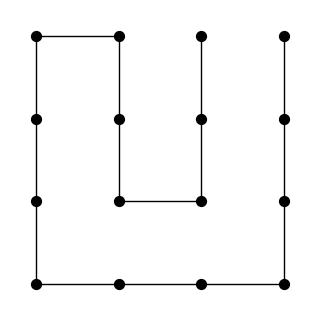

In [95]:
# Load the Pickle file
with open('tdvp_profiling_data.pkl', 'rb') as f:
    profiling_data = pickle.load(f)

# Extract profiling details from the loaded data
profiling_details = profiling_data['profiling_details']

config_id = 'Config 82'
ttn = profiling_details[config_id]['Spanning_tree']
ptn.Visualize_tree(profiling_details[config_id]['tree_dict'],6)  

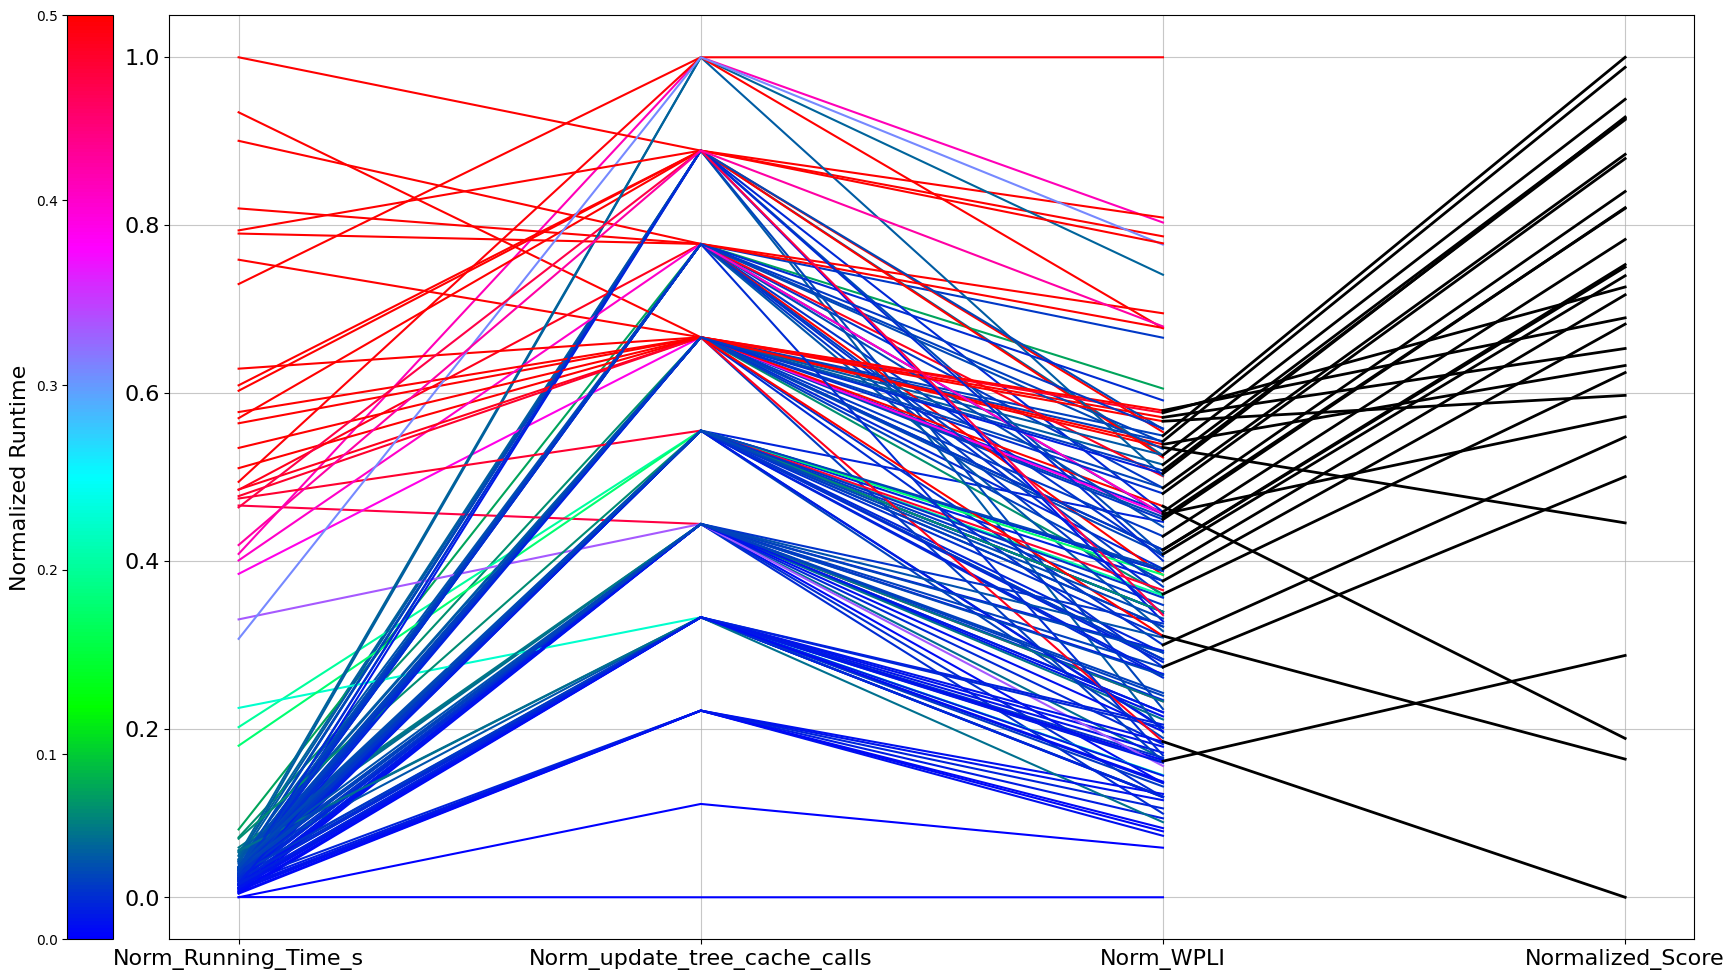

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

def plot_parallel_coordinates_with_score(profiling_data, cache_calls_ncalls, alpha=1, gamma=1):
    """
    Generate a Parallel Coordinates Plot for profiling data with a vibrant heatmap color
    based on Running_Time_s and an additional "Score" row for a specific cache_calls_ncalls.

    Parameters:
        profiling_data (list of dicts): Profiling data with keys including 
                                        'Config_ID', 'Running_Time_s', 
                                        'update_tree_cache_calls', and 'WPLI'.
        cache_calls_ncalls (int): The specific cache_calls value to process.
        alpha, gamma (float): Weights for Running Time and WPLI in scoring.
    """
    # Compute scores for the specific cache_calls_ncalls
    subset_data = ptn.compute_scores(profiling_data, cache_calls_ncalls, alpha, gamma)

    # Convert profiling data to a DataFrame
    df = pd.DataFrame(profiling_data)
    subset_df = pd.DataFrame(subset_data)

    # Normalize the columns for better comparison
    df['Norm_Running_Time_s'] = (df['Running_Time_s'] - df['Running_Time_s'].min()) / (df['Running_Time_s'].max() - df['Running_Time_s'].min())
    df['Norm_update_tree_cache_calls'] = (df['update_tree_cache_calls'] - df['update_tree_cache_calls'].min()) / (df['update_tree_cache_calls'].max() - df['update_tree_cache_calls'].min())
    df['Norm_WPLI'] = (df['WPLI'] - df['WPLI'].min()) / (df['WPLI'].max() - df['WPLI'].min())
    
    subset_df['Norm_WPLI'] = (subset_df['WPLI'] - df['WPLI'].min()) / (df['WPLI'].max() - df['WPLI'].min())

    # Assign vibrant colors based on Running_Time_s using a stretched colormap
    norm = Normalize(vmin=df['Norm_Running_Time_s'].min(), vmax=df['Norm_Running_Time_s'].max() * 0.5)  # Stretch range for better differentiation
    colors = ["#0000FF", "#00FF00", "#00FFFF", "#FF00FF", "#FF0000"]  # Blue to Green to Cyan to Magenta to Red
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    df['Color'] = [cmap(norm(value)) for value in df['Norm_Running_Time_s']]

    # Create the Parallel Coordinates Plot
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot all data for the first three coordinates with original vibrant colors
    for i, row in df.iterrows():
        ax.plot(
            ['Norm_Running_Time_s', 'Norm_update_tree_cache_calls', 'Norm_WPLI'], 
            [row['Norm_Running_Time_s'], row['Norm_update_tree_cache_calls'], row['Norm_WPLI']], 
            color=row['Color'], alpha=1
        )

    # Plot only the specific cache_calls_ncalls for Norm_WPLI to Normalized_Score in black
    for i, row in subset_df.iterrows():
        ax.plot(
            ['Norm_WPLI', 'Normalized_Score'], 
            [row['Norm_WPLI'], row['Normalized_Score']], 
            color="black", alpha=1, linewidth=2
        )

    # Format tick labels
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
    for label in ax.get_yticklabels():
        label.set_fontsize(16)

    # Create a dedicated colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', location='left', pad=0.03)
    cbar.set_label('Normalized Runtime', fontsize=16)

    # Add grid and show the plot
    ax.grid(True, alpha=0.7)
    plt.show()

# Extract the list of profiling entries
profiling_entries = profiling_data['profiling_data']

# Call the plotting function with the extracted list
plot_parallel_coordinates_with_score(profiling_entries, 42, alpha=1, gamma=1)


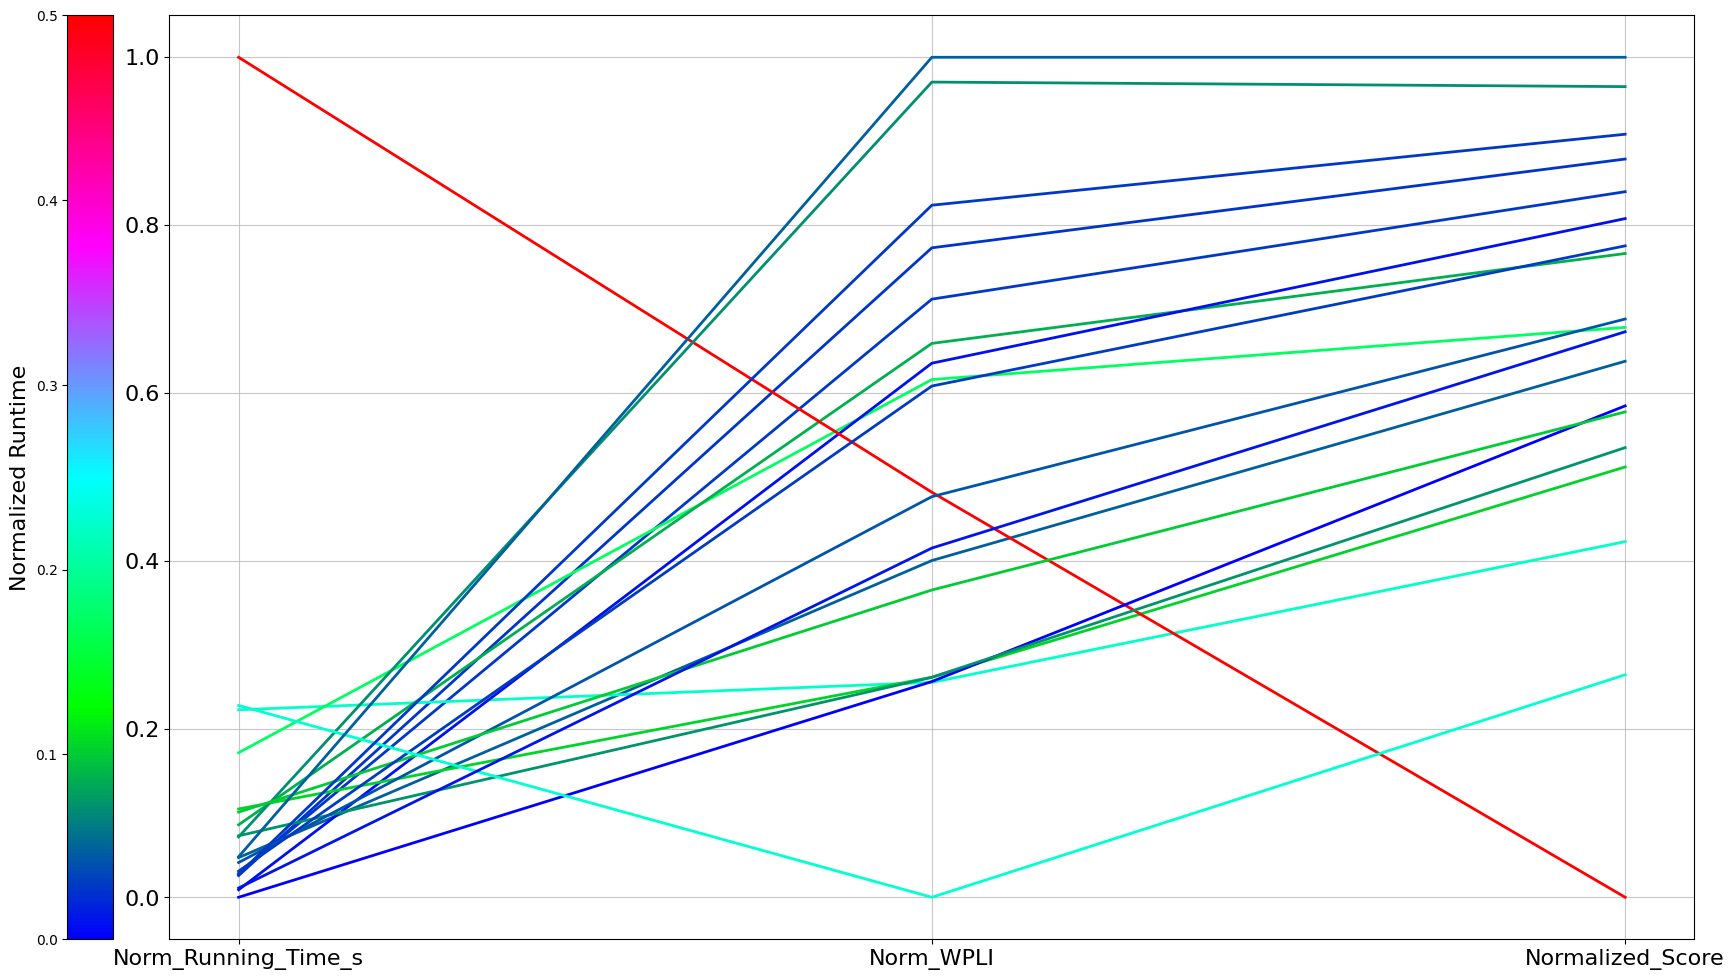

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

def plot_parallel_coordinates_with_score(profiling_data, cache_calls_ncalls, alpha=1, gamma=1):
    """
    Generate a Parallel Coordinates Plot for profiling data with a vibrant heatmap color based on Running_Time_s
    and an additional "Score" row for a specific cache_calls_ncalls.

    Parameters:
        profiling_data (list of dicts): Profiling data with keys including 
                                        'Config_ID', 'Running_Time_s', 
                                        'update_tree_cache_calls', and 'WPLI'.
        cache_calls_ncalls (int): The specific cache_calls value to process.
        alpha, gamma (float): Weights for Running Time and WPLI in scoring.
    """
    # Compute scores for the specific cache_calls_ncalls
    subset_data = ptn.compute_scores(profiling_data, cache_calls_ncalls, alpha, gamma)

    # Convert the filtered profiling data to a DataFrame
    df = pd.DataFrame(subset_data)

    # Normalize the columns for better comparison
    df['Norm_Running_Time_s'] = (df['Running_Time_s'] - df['Running_Time_s'].min()) / (df['Running_Time_s'].max() - df['Running_Time_s'].min())
    df['Norm_WPLI'] = (df['WPLI'] - df['WPLI'].min()) / (df['WPLI'].max() - df['WPLI'].min())

    # Assign vibrant colors based on Running_Time_s using a stretched colormap
    norm = Normalize(vmin=df['Norm_Running_Time_s'].min(), vmax=df['Norm_Running_Time_s'].max() * 0.5)  # Stretch range for better differentiation
    colors = ["#0000FF", "#00FF00", "#00FFFF", "#FF00FF", "#FF0000"]  # Blue to Green to Cyan to Magenta to Red
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    df['Color'] = [cmap(norm(value)) for value in df['Norm_Running_Time_s']]

    # Create the Parallel Coordinates Plot
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot the data for the specific cache_calls_ncalls
    for i, row in df.iterrows():
        ax.plot(
            ['Norm_Running_Time_s', 'Norm_WPLI', 'Normalized_Score'], 
            [row['Norm_Running_Time_s'], row['Norm_WPLI'], row['Normalized_Score']], 
            color=row['Color'], alpha=1, linewidth=2
        )

    # Format tick labels
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
    for label in ax.get_yticklabels():
        label.set_fontsize(16)

    # Create a dedicated colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', location='left', pad=0.03)
    cbar.set_label('Normalized Runtime', fontsize=16)

    # Add grid and show the plot
    ax.grid(True, alpha=0.7)
    plt.show()

# Example Usage
# Ensure you call compute_scores and plot_parallel_coordinates_with_score with valid profiling_data.
# plot_parallel_coordinates_with_score(profiling_data, cache_calls_ncalls=42, alpha=1, gamma=1)

# Extract the list of profiling entries
profiling_entries = loaded_data['profiling_data']

# Example Usage
plot_parallel_coordinates_with_score(profiling_data, cache_calls_ncalls = 36, alpha=1, gamma=1)

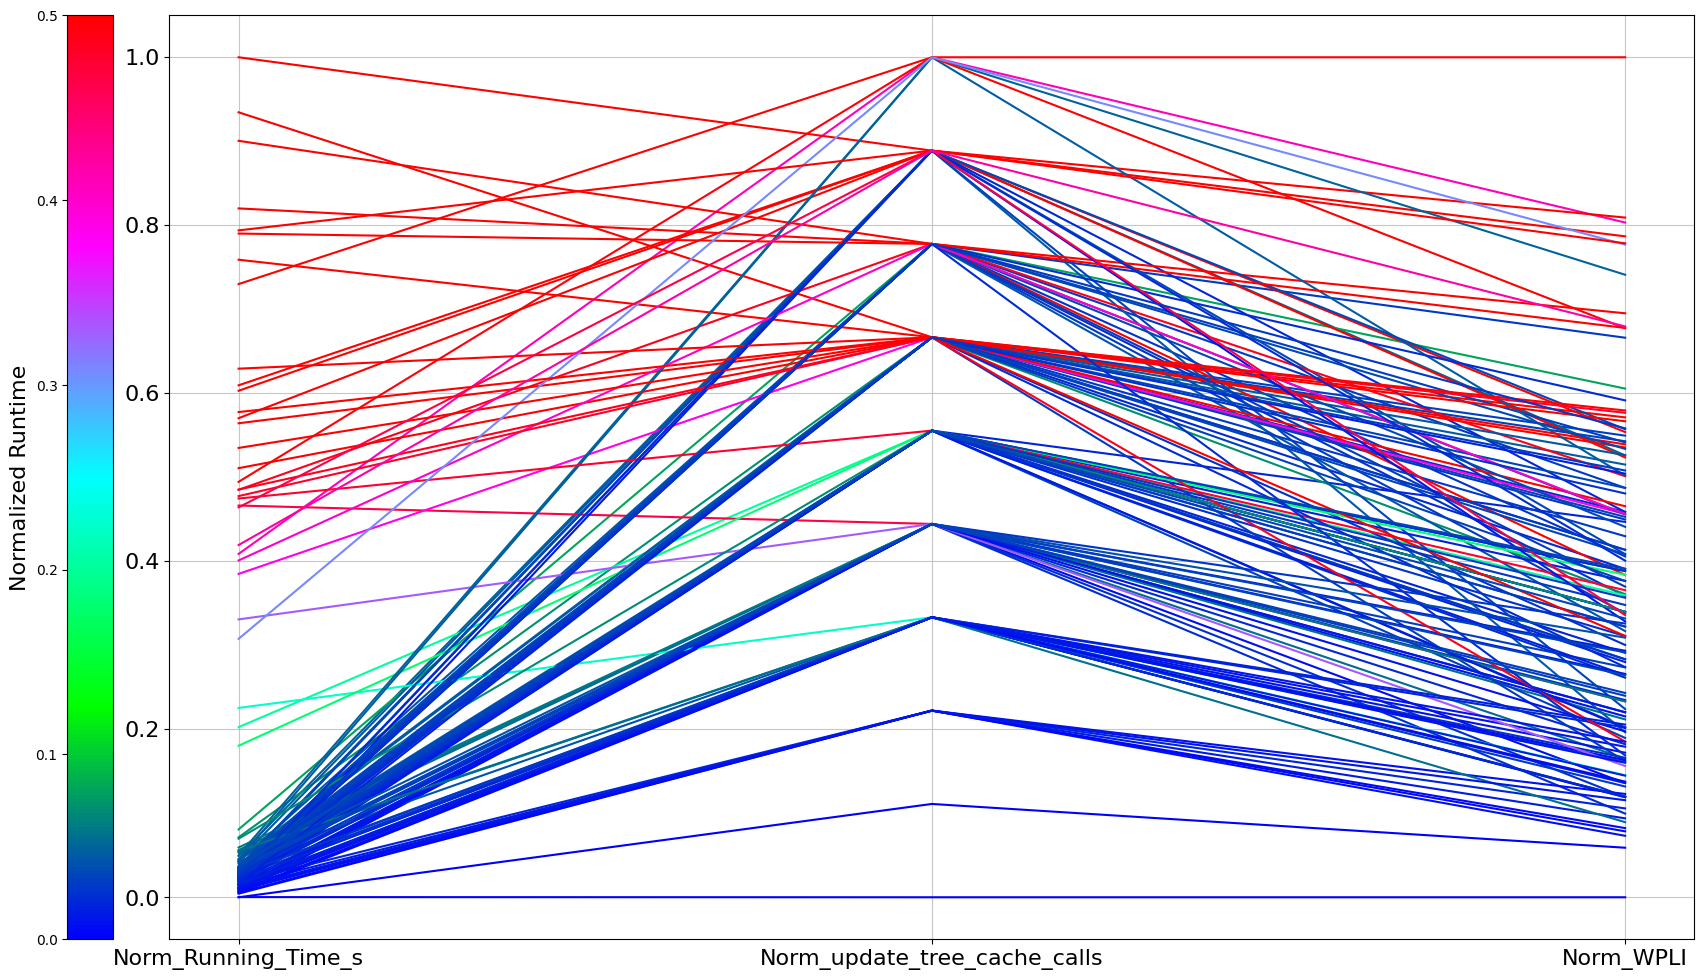

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

def plot_parallel_coordinates(profiling_data):
    """
    Generate a Parallel Coordinates Plot for profiling data with a vibrant heatmap color
    based on Running_Time_s.

    Parameters:
        profiling_data (list of dicts): Profiling data with keys including 
                                        'Config_ID', 'Running_Time_s', 
                                        'update_tree_cache_calls', and 'WPLI'.
    """
    # Convert profiling data to a DataFrame
    df = pd.DataFrame(profiling_data)

    # Normalize the columns for better comparison
    df['Norm_Running_Time_s'] = (df['Running_Time_s'] - df['Running_Time_s'].min()) / (df['Running_Time_s'].max() - df['Running_Time_s'].min())
    df['Norm_update_tree_cache_calls'] = (df['update_tree_cache_calls'] - df['update_tree_cache_calls'].min()) / (df['update_tree_cache_calls'].max() - df['update_tree_cache_calls'].min())
    df['Norm_WPLI'] = (df['WPLI'] - df['WPLI'].min()) / (df['WPLI'].max() - df['WPLI'].min())

    # Assign vibrant colors based on Running_Time_s using a stretched colormap
    norm = Normalize(vmin=df['Norm_Running_Time_s'].min(), vmax=df['Norm_Running_Time_s'].max() * 0.5)  # Stretch range for better differentiation
    colors = ["#0000FF", "#00FF00", "#00FFFF", "#FF00FF", "#FF0000"]  # Blue to Green to Cyan to Magenta to Red
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    df['Color'] = [cmap(norm(value)) for value in df['Norm_Running_Time_s']]

    # Create the Parallel Coordinates Plot
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot all data for the specified coordinates with original vibrant colors
    for i, row in df.iterrows():
        ax.plot(
            ['Norm_Running_Time_s', 'Norm_update_tree_cache_calls', 'Norm_WPLI'], 
            [row['Norm_Running_Time_s'], row['Norm_update_tree_cache_calls'], row['Norm_WPLI']], 
            color=row['Color'], alpha=1
        )

    # Format tick labels
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
    for label in ax.get_yticklabels():
        label.set_fontsize(16)

    # Create a dedicated colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', location='left', pad=0.03)
    cbar.set_label('Normalized Runtime', fontsize=16)

    # Add grid and show the plot
    ax.grid(True, alpha=0.7)
    plt.show()

# Example Usage
plot_parallel_coordinates(profiling_data)
